## Step 0: Imports

In [40]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import beta

## Step 1: Transform and split the data

In [12]:
kuairec_df = pd.read_csv('KuaiRec 2.0/data/small_matrix.csv')

In [13]:
kuairec_df['liked'] = kuairec_df['watch_ratio'] > 1.95
kuairec_df['liked'] = kuairec_df['liked'].astype(int)

In [16]:
video_df = kuairec_df.groupby(['video_id']).mean()['liked']

In [21]:
train_videos, test_videos = train_test_split(video_df, test_size = 0.4)

In [31]:
# look up zero-inflated fits for beta, we're throwing out a small fraction of 0-like videos
prior_a, prior_b, loc, scale = beta.fit([i for i in train_videos.values if i != 0], floc=0, fscale=1)

In [38]:
r = beta.rvs(prior_a, prior_b, size=5000)

Text(0.5, 1.0, 'density plot of eb beta prior')

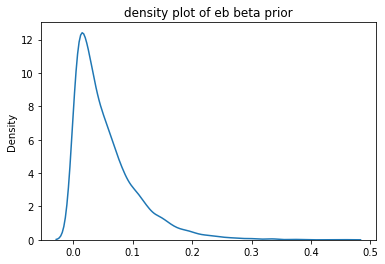

In [159]:
sns.kdeplot(r).set_title('density plot of eb beta prior')

## Step 2: Merge the datasets and select from test set different products

In [47]:
kuairec_test = pd.merge(kuairec_df, test_videos, on='video_id')
kuairec_test = kuairec_test.rename(columns={'liked_x': 'liked', 'liked_y': 'like_ratio'})

In [48]:
kuairec_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,liked,like_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,0,0.127706
1,19,148,8167,6067,2020-07-23 12:08:54.16,20200723.0,1.595477e+09,1.346135,0,0.127706
2,21,148,8811,6067,2020-07-05 16:49:12.936,20200705.0,1.593939e+09,1.452283,0,0.127706
3,23,148,11538,6067,2020-07-11 22:32:48.746,20200711.0,1.594478e+09,1.901764,0,0.127706
4,24,148,12856,6067,2020-07-19 08:14:18.039,20200719.0,1.595118e+09,2.119004,1,0.127706


Text(0.5, 1.0, 'histogram of like ratios')

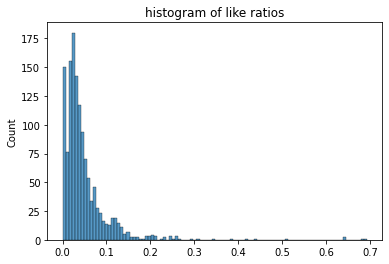

In [158]:
sns.histplot(test_videos.values).set_title('histogram of like ratios')

In [56]:
test_videos[test_videos > 0.6]

video_id
600     0.679660
154     0.692690
5525    0.640680
4123    0.639263
Name: liked, dtype: float64

In [130]:
sampled_videos = list(test_videos[test_videos <= 0.6].sample(4, random_state=1729).keys())
sampled_videos.append(600)

In [131]:
sampled_videos

[8530, 8404, 6898, 7559, 600]

In [132]:
kuairec_chosen = kuairec_test[kuairec_test['video_id'].isin(sampled_videos)]

In [155]:
kuairec_chosen[['video_id', 'like_ratio']].drop_duplicates()

,video_id,like_ratio
203725,6898,0.018427
246010,8530,0.032601
274147,8404,0.028086
370957,600,0.679660
1272090,7559,0.253012


## Step 3: Set up the bandit environment

In [134]:
# set up experiment in a way where we can later interpolate between uninformed prior and eb
uninformed_priors = np.ones(len(sampled_videos)*2).reshape(len(sampled_videos),2)
eb_priors = np.array([[prior_a]*len(sampled_videos),[prior_b]*len(sampled_videos)]).T

In [135]:
def random_argmax(alist):
  maxval = max(alist)
  argmax = [idx for idx, val in enumerate(alist) if val == maxval]
  return np.random.choice(argmax)

def ts_action(actions, num_success, num_failure):
  p_hat = [np.random.beta(num_success[a],num_failure[a]) for a in actions]
  a = random_argmax(p_hat)
  return a

def sample_chosen_df(videos, chosen_df, action_index):
    vid = videos[action_index]
    seen_like = chosen_df[chosen_df['video_id']==vid].sample(1).iloc[0]['liked']
    return seen_like

In [136]:
def run_multiarmed_bandit(chosen_df, 
                          videos, 
                          priors, 
                          sampling_action, 
                          timesteps, 
                          num_sims):

    agg_priors_over_time = None
    rewards_over_time = None
    
    for n in range(num_sims):
        instance_priors_over_time = [priors]
        instance_rewards_over_time = [np.zeros(len(videos))]
        
        for t in range(timesteps):
            newest_prior = instance_priors_over_time[-1].copy()
            newest_rewards = instance_rewards_over_time[-1].copy()
            successes, failures = newest_prior.T[0,:], newest_prior.T[1,:]
            actions = range(len(videos))
            
            a = sampling_action(actions, successes, failures)
            
            like = sample_chosen_df(videos, chosen_df, a)
            
            # update prior
            newest_prior[a,0] += like
            newest_prior[a,1] += 1 - like
            instance_priors_over_time.append(newest_prior)
            
            newest_rewards[a] += like
            instance_rewards_over_time.append(newest_rewards)
            
        instance_priors_over_time = np.stack(instance_priors_over_time)
        instance_rewards_over_time = np.stack(instance_rewards_over_time)
        
        if agg_priors_over_time is None:
            agg_priors_over_time = instance_priors_over_time
        else:
            agg_priors_over_time += instance_priors_over_time
            
        if rewards_over_time is None:
            rewards_over_time = instance_rewards_over_time
        else:
            rewards_over_time += instance_rewards_over_time
            
    return agg_priors_over_time/num_sims, rewards_over_time/num_sims
            
        

## Step 4: Run the simulations and save data

In [144]:
timesteps = 1000
num_sims = 10

In [145]:
uninformed_prior_data, uninformed_rewards_data = run_multiarmed_bandit(kuairec_chosen,
                                                                       sampled_videos,
                                                                       uninformed_priors,
                                                                       ts_action,
                                                                       timesteps=timesteps,
                                                                       num_sims=num_sims)

In [147]:
eb_prior_data, eb_rewards_data = run_multiarmed_bandit(kuairec_chosen,
                                                       sampled_videos,
                                                       eb_priors,
                                                       ts_action,
                                                       timesteps=timesteps,
                                                       num_sims=num_sims)

## Step 5: Plot and analyze the data

In [151]:
uninformed_means = uninformed_prior_data[:,:,0]/(uninformed_prior_data[:,:,0]+uninformed_prior_data[:,:,1])

In [156]:
eb_means = eb_prior_data[:,:,0]/(eb_prior_data[:,:,0] + eb_prior_data[:,:,1])

Text(0.5, 1.0, 'estimated quality, uninformed prior')

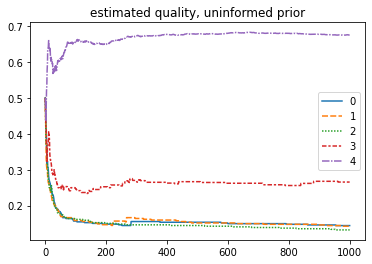

In [160]:
sns.lineplot(uninformed_means).set_title('estimated quality, uninformed prior')

Text(0.5, 1.0, 'estimated quality, eb prior')

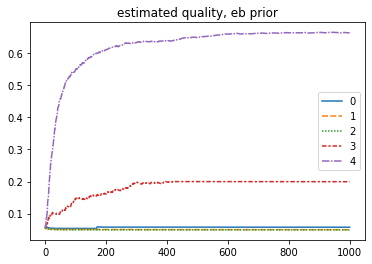

In [161]:
sns.lineplot(eb_means).set_title('estimated quality, eb prior')